In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arnabbiswas1/microsoft-azure-predictive-maintenance")

print("Path to dataset files:", path)

100%|██████████| 31.0M/31.0M [00:00<00:00, 131MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance/versions/3


In [7]:
!mkdir -p data
!cp /root/.cache/kagglehub/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance/versions/3/*.csv data/


In [8]:
# Step 1: Load raw data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
telemetry = pd.read_csv("/content/data/PdM_telemetry.csv")
machines = pd.read_csv("/content/data/PdM_machines.csv")
errors = pd.read_csv("/content/data/PdM_errors.csv")
maint = pd.read_csv("/content/data/PdM_maint.csv")
failures = pd.read_csv("/content/data/PdM_failures.csv")

In [12]:
# Step 2: Explore basic info
print("Telemetry:\n", telemetry.head())
print("Machines:\n", machines.head())
print("Errors:\n", errors.head())
print("Maintenance:\n", maint.head())
print("Failures:\n", failures.head())

Telemetry:
               datetime  machineID        volt      rotate    pressure  \
0  2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1  2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
2  2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
3  2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
4  2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   

   vibration  
0  45.087686  
1  43.413973  
2  34.178847  
3  41.122144  
4  25.990511  
Machines:
    machineID   model  age
0          1  model3   18
1          2  model4    7
2          3  model3    8
3          4  model3    7
4          5  model3    2
Errors:
               datetime  machineID errorID
0  2015-01-03 07:00:00          1  error1
1  2015-01-03 20:00:00          1  error3
2  2015-01-04 06:00:00          1  error5
3  2015-01-10 15:00:00          1  error4
4  2015-01-22 10:00:00          1  error4
Maintenance:
               dat

In [13]:
# Step 3: Check for missing values
print("Missing values:")
for df, name in zip([telemetry, machines, errors, maint, failures],
                    ["Telemetry", "Machines", "Errors", "Maint", "Failures"]):
    print(f"{name}: {df.isnull().sum().sum()} missing")

Missing values:
Telemetry: 0 missing
Machines: 0 missing
Errors: 0 missing
Maint: 0 missing
Failures: 0 missing


In [14]:
# Step 4: Class distribution (failures)
print("Failure types:\n", failures["failure"].value_counts())

Failure types:
 failure
comp2    259
comp1    192
comp4    179
comp3    131
Name: count, dtype: int64


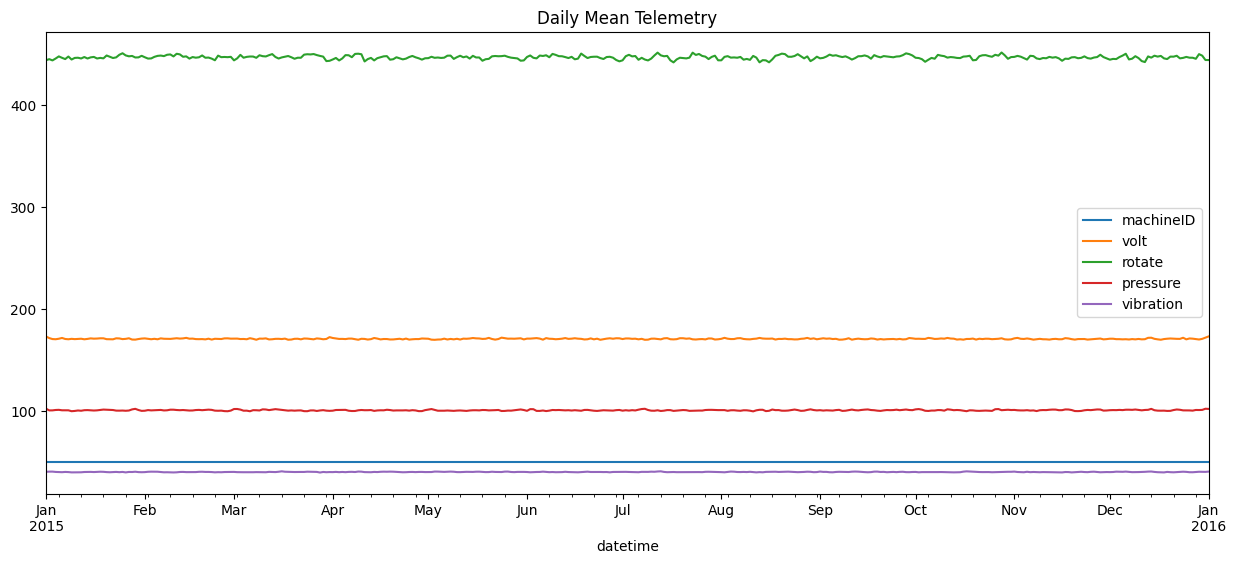

In [15]:
# Step 5: Visualize telemetry stats
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])
telemetry.set_index('datetime', inplace=True)
telemetry.resample('1D').mean().plot(figsize=(15, 6), title="Daily Mean Telemetry")
plt.show()

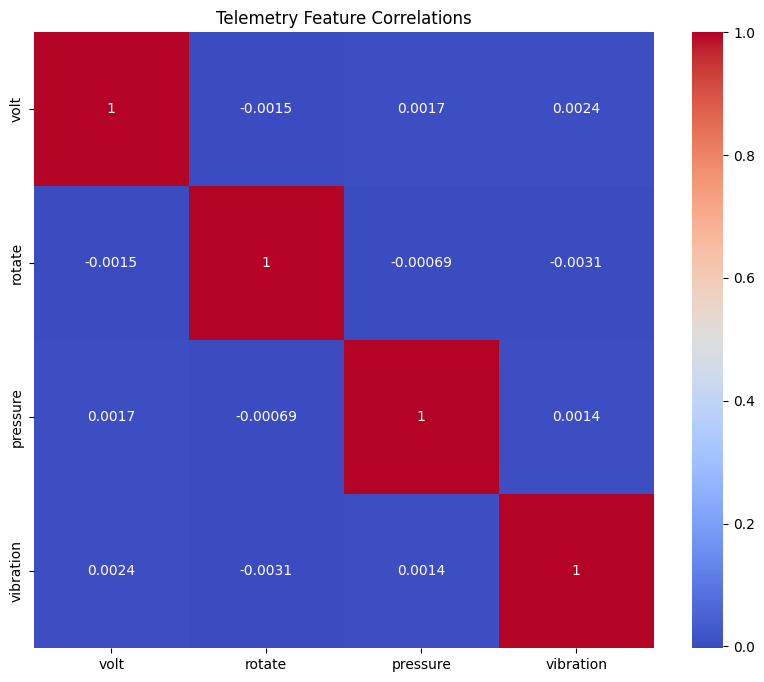

In [16]:

# Step 6: Visualize correlations
telemetry_corr = telemetry.drop(columns=['machineID']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(telemetry_corr, annot=True, cmap='coolwarm')
plt.title("Telemetry Feature Correlations")
plt.show()


In [18]:
def load_raw_data():
    telemetry = pd.read_csv("/content/data/PdM_telemetry.csv", parse_dates=["datetime"])
    machines = pd.read_csv("/content/data/PdM_machines.csv")
    errors = pd.read_csv("/content/data/PdM_errors.csv", parse_dates=["datetime"])
    maint = pd.read_csv("/content/data/PdM_maint.csv", parse_dates=["datetime"])
    failures = pd.read_csv("/content/data/PdM_failures.csv", parse_dates=["datetime"])
    return telemetry, machines, errors, maint, failures

import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder

def preprocess_and_merge(telemetry, machines, errors, maint, failures):
    # Step 1: Aggregate telemetry (e.g., 3-hour averages)
    agg_telemetry = telemetry.groupby(
        ['machineID', pd.Grouper(key='datetime', freq='3h')]  # <- lowercase 'h' fixes FutureWarning
    ).mean().reset_index()

    # Step 2: Merge with machine metadata
    df = agg_telemetry.merge(machines, on='machineID', how='left')

    # Step 3: Encode the 'model' column using LabelEncoder
    le = LabelEncoder()
    df['model'] = le.fit_transform(df['model'])

    # Step 4: Add binary target label - failure within 24 hours
    failures['label'] = 1
    df['failure_within_24h'] = 0
    for i, row in failures.iterrows():
        mid = row['machineID']
        fail_time = row['datetime']
        mask = (
            (df['machineID'] == mid) &
            (df['datetime'] >= fail_time - timedelta(hours=24)) &
            (df['datetime'] < fail_time)
        )
        df.loc[mask, 'failure_within_24h'] = 1

    # Step 5: Drop any NaNs created from rolling or merging
    return df.dropna()



In [19]:
telemetry, machines, errors, maint, failures = load_raw_data()
df = preprocess_and_merge(telemetry, machines, errors, maint, failures)


In [20]:
# Step 8: Final dataset inspection
print("Final dataset shape:", df.shape)
print("Target class distribution:\n", df["failure_within_24h"].value_counts())

Final dataset shape: (292100, 9)
Target class distribution:
 failure_within_24h
0    286372
1      5728
Name: count, dtype: int64


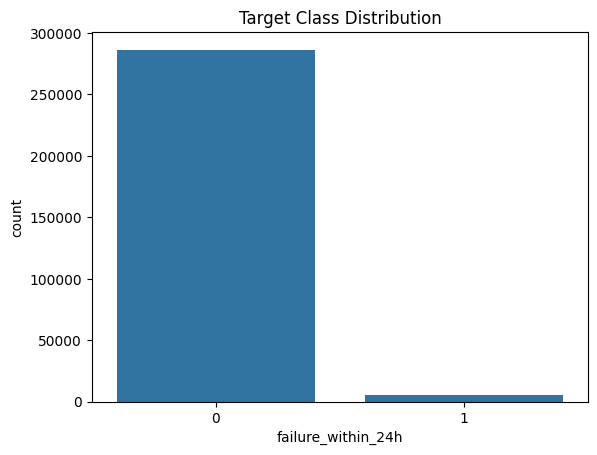

In [21]:
# Step 9: Visualize class imbalance
sns.countplot(data=df, x="failure_within_24h")
plt.title("Target Class Distribution")
plt.show()
